# Compare Hail VEP output VS Docker VEP output.
## Step 1: Convert Hail Table to flattened TSV:

In [22]:
import hail as hl
import pandas as pd
hl.stop()
hl.init()

file="data/vep-hail-out/genebass.hailvep.gnomad_process_csqs.chr21.ht"

vep = hl.read_table(file)

vep = vep.annotate(worst_csq_by_gene_canonical = vep.vep.worst_csq_by_gene_canonical)
vep = vep.drop('vep')
vep = vep.explode('worst_csq_by_gene_canonical')
vep = vep.flatten()
vep.export(f"data/vep-hail-out/genebass.hailvep.gnomad_process_csqs.chr21.tsv")

Running on Apache Spark version 3.3.2
SparkUI available at http://compe031.hpc.in.bmrc.ox.ac.uk:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.115-10932c754edb
LOGGING: writing to /gpfs3/well/lindgren/barney/brava-ground-truth-annotations/hail-20230814-1315-0.2.115-10932c754edb.log


## Step 2: Import both TSV's - Basic Comparisons:

In [24]:
import pandas as pd

docker_vep = pd.read_csv('data/docker-vep-out/genebass.chr21.txt', sep=' ')

# Filter docker vep to canonical, protein_coding transcripts
docker_vep = docker_vep[(docker_vep["BIOTYPE"] == "protein_coding") &
                        ((docker_vep["MANE_SELECT"] != ".") |
                         ((docker_vep["MANE_SELECT"] == ".") & (docker_vep["CANONICAL"] == "YES")))]

# Construct the equivalent SNP_ID for hail_vep by combining locus and alleles columns
hail_vep['SNP_ID'] = hail_vep['locus'] + ':' + hail_vep['alleles'].str.replace('[\[\]" ]', '').str.replace(',', ':')
docker_vep['SNP_ID'] = 'chr' + docker_vep['SNP_ID']

hail_vep_subset = hail_vep[['SNP_ID', 'worst_csq_by_gene_canonical.gene_id', 'worst_csq_by_gene_canonical.most_severe_consequence']]
docker_vep_subset = docker_vep[['SNP_ID', 'GENE', 'CSQ']]

# Merge dataframes on SNP_ID/locus and GENE/gene_id to find the overlap
overlap = pd.merge(hail_vep_subset, docker_vep_subset, left_on=['SNP_ID', 'worst_csq_by_gene_canonical.gene_id'], 
                   right_on=['SNP_ID', 'GENE'], how='inner')

print(f"Number of overlapping entries between Hail VEP and Docker VEP: {len(overlap)}")
print(f"Number of unique entries in Hail VEP: {hail_vep_subset.drop_duplicates().shape[0]}")
print(f"Number of unique entries in Docker VEP: {docker_vep_subset.drop_duplicates().shape[0]}")

# Check for entries in Hail VEP not present in Docker VEP
missing_in_docker = hail_vep_subset.loc[~hail_vep_subset.set_index(['SNP_ID', 'worst_csq_by_gene_canonical.gene_id']).index.isin(overlap.set_index(['SNP_ID', 'worst_csq_by_gene_canonical.gene_id']).index)]
print(f"Entries in Hail VEP not present in Docker VEP: {len(missing_in_docker)}")

# Check for entries in Docker VEP not present in Hail VEP
missing_in_hail = docker_vep_subset.loc[~docker_vep_subset.set_index(['SNP_ID', 'GENE']).index.isin(overlap.set_index(['SNP_ID', 'GENE']).index)]
print(f"Entries in Docker VEP not present in Hail VEP: {len(missing_in_hail)}")

/well/lindgren/users/hjo721/conda/skylake/envs/popgen/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


Number of overlapping entries between Hail VEP and Docker VEP: 98438
Number of unique entries in Hail VEP: 98438
Number of unique entries in Docker VEP: 98498
Entries in Hail VEP not present in Docker VEP: 0
Entries in Docker VEP not present in Hail VEP: 60


In [25]:
pd.merge(missing_in_hail, docker_vep, left_on=['SNP_ID', 'GENE'], right_on=['SNP_ID', 'GENE'], how='left')

,SNP_ID,GENE,CSQ_x,LOF,MAX_AF,REVEL_SCORE,CADD_PHRED,CSQ_y,TRANSCRIPT,MANE_SELECT,CANONICAL,BIOTYPE
0,chr21:5128279:G:A,ENSG00000275464,downstream_gene_variant,.,.,.,.,downstream_gene_variant,ENST00000617716,NM_001368238.1,YES,protein_coding
1,chr21:5128282:C:A,ENSG00000275464,downstream_gene_variant,.,.,.,.,downstream_gene_variant,ENST00000617716,NM_001368238.1,YES,protein_coding
2,chr21:5128282:C:T,ENSG00000275464,downstream_gene_variant,.,.,.,.,downstream_gene_variant,ENST00000617716,NM_001368238.1,YES,protein_coding
3,chr21:5128283:G:A,ENSG00000275464,downstream_gene_variant,.,.,.,.,downstream_gene_variant,ENST00000617716,NM_001368238.1,YES,protein_coding
4,chr21:5128286:G:A,ENSG00000275464,downstream_gene_variant,.,.,.,.,downstream_gene_variant,ENST00000617716,NM_001368238.1,YES,protein_coding
5,chr21:5128289:G:C,ENSG00000275464,downstream_gene_variant,.,.,.,.,downstream_gene_variant,ENST00000617716,NM_001368238.1,YES,protein_coding
6,chr21:5128290:G:T,ENSG00000275464,downstream_gene_variant,.,.,.,.,downstream_gene_variant,ENST00000617716,NM_001368238.1,YES,protein_coding
7,chr21:5128295:G:A,ENSG00000275464,downstream_gene_variant,.,.,.,.,downstream_gene_variant,ENST00000617716,NM_001368238.1,YES,protein_coding
8,chr21:5128318:C:A,ENSG00000275464,downstream_gene_variant,.,.,.,.,downstream_gene_variant,ENST00000617716,NM_001368238.1,YES,protein_coding
9,chr21:5128318:C:G,ENSG00000275464,downstream_gene_variant,.,.,.,.,downstream_gene_variant,ENST00000617716,NM_001368238.1,YES,protein_coding


In [27]:
# Just for the consequence comparison filter down to single consequences
# this is because finding the worse consequence will be handled in the python annotation script
overlap['CSQ'] = overlap['CSQ'].str.split('&')
overlap = overlap[overlap['CSQ'].str.len() == 1]

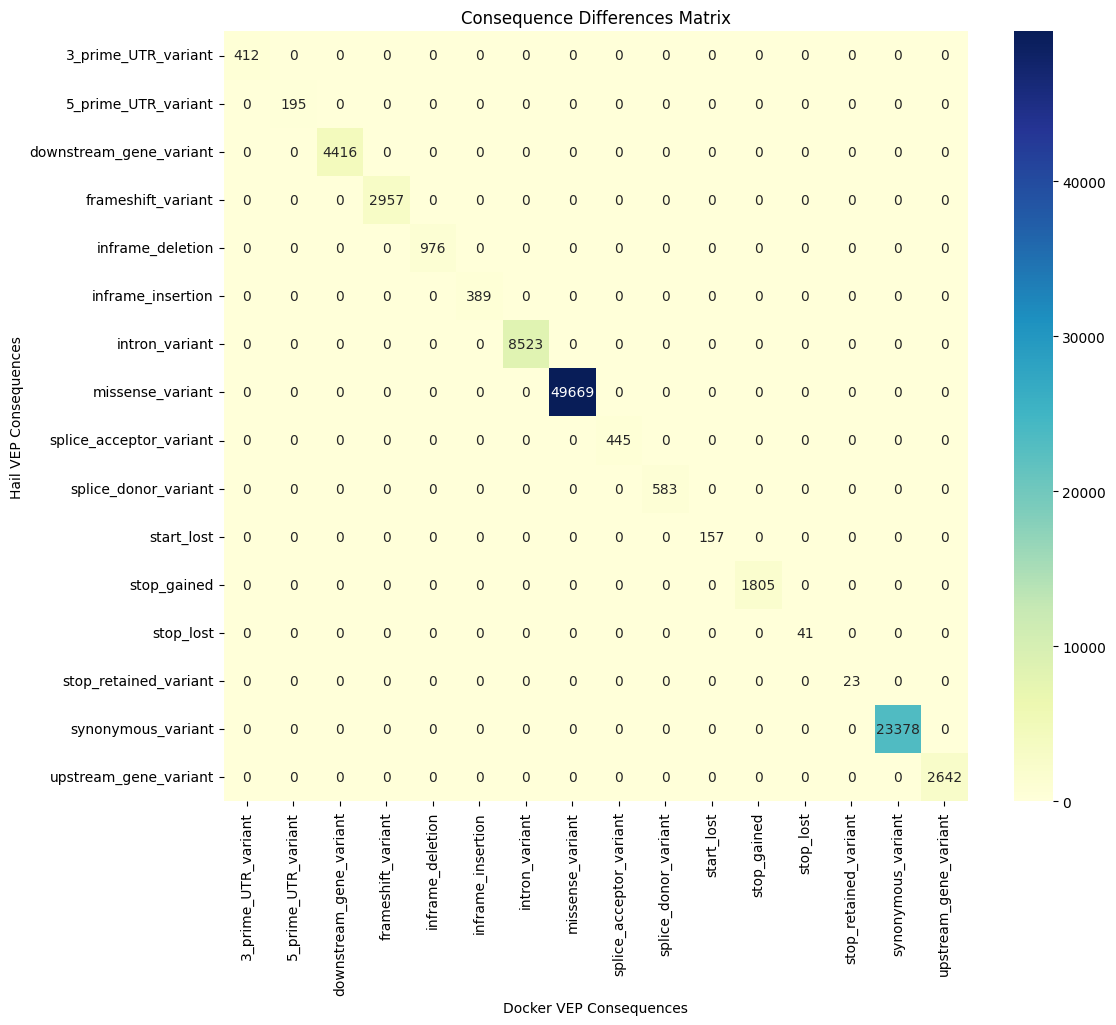

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

consequence_matrix = pd.crosstab(overlap['worst_csq_by_gene_canonical.most_severe_consequence'], overlap['CSQ'].str.join(''))

# Plotting the matrix
plt.figure(figsize=(12, 10))
sns.heatmap(consequence_matrix, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Consequence Differences Matrix")
plt.xlabel("Docker VEP Consequences")
plt.ylabel("Hail VEP Consequences")
plt.show()